In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 8
img_height = 197
img_width = 200

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "dataset/both",
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-06 20:10:24.247896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-06 20:10:24.248252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "dataset/both",
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 200 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 197, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 197, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 100, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 100, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 50, 64)        1

In [11]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-05-06 20:13:03.289595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 99/100 [============================>.] - ETA: 0s - loss: 0.8162 - accuracy: 0.7715

2023-05-06 20:13:08.389974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 6s 26ms/step - loss: 0.8080 - accuracy: 0.7738 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - 2s 24ms/step - loss: 4.9341e-04 - accuracy: 1.0000 - val_loss: 2.8292e-04 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 2s 22ms/step - loss: 2.0921e-04 - accuracy: 1.0000 - val_loss: 1.7274e-04 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 2s 22ms/step - loss: 1.2895e-04 - accuracy: 1.0000 - val_loss: 1.0888e-04 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 2s 22ms/step - loss: 8.6821e-05 - accuracy: 1.0000 - val_loss: 7.8336e-05 - val_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 2s 22ms/step - loss: 6.0843e-05 - accuracy: 1.0000 - val_loss: 5.6434e-05 - val_accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 2s 22ms/step - loss: 4.6946e-05 - accuracy: 1.0000 - val_lo

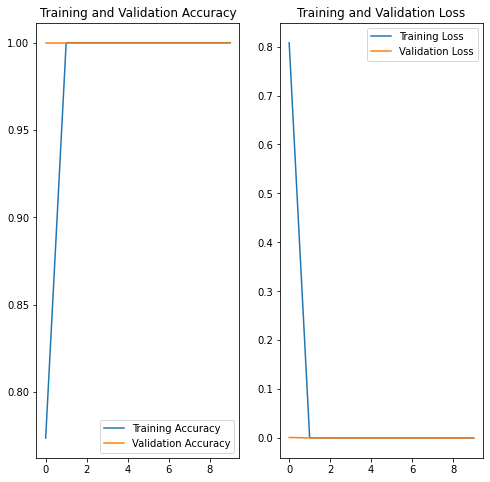

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
def recognize_image(path):
    img = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [16]:
recognize_image("dataset/both/0/1zero.jpg")
recognize_image("dataset/both/0/2zero.jpg")
recognize_image("dataset/both/0/3zero.jpg")
recognize_image("dataset/both/0/4zero.jpg")
recognize_image("dataset/both/0/5zero.jpg")
recognize_image("dataset/both/1/28one.jpg")
recognize_image("dataset/both/0/30zero.jpg")
recognize_image("dataset/both/0/9zero.jpg")

This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 1 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.


In [17]:
# save model to file
model.save("model.h5")